### Importing Required Libraries for Training U-Net Model

In [ ]:
# Importing required libraries

import os
import sys
import time
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, matthews_corrcoef, f1_score


sys.path.append('~/Thesis/Data')

### Grapical Processing Unit (GPU) information

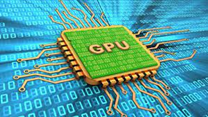

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

### Loading Input Data (Train,Validation,Test) as NumPy arrays

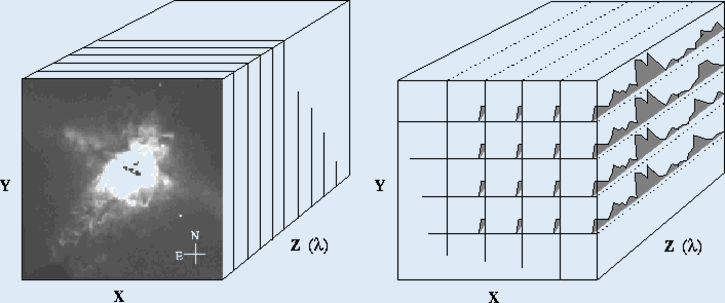

In [ ]:
#Loading training,validation and testing datasets

X_train = np.load(f'~/Thesis/MSI/Patch_256/arrays/X_train.npy')
Y_train = np.load(f'~/Thesis/MSI/Patch_256/arrays/Y_train.npy')
X_val = np.load(f'~/Thesis/MSI/Patch_256/arrays/X_val.npy')
Y_val = np.load(f'~/Thesis/MSI/Patch_256/arrays/Y_val.npy')
X_test = np.load(f'~/Thesis/MSI/Patch_256/arrays/X_test.npy')
Y_test = np.load(f'~/Thesis/MSI/Patch_256/arrays/Y_test.npy')

print("Shape of the training dataset (satellite image): ", X_train.shape)
print("Shape of the training dataset (label image): ",Y_train.shape)
print("Shape of the validation dataset (satellite image): ",X_val.shape)
print("Shape of the validation dataset (label image): ",Y_val.shape)
print("Shape of the testing dataset (satellite image): ",X_test.shape)
print("Shape of the testing dataset (label image): ",Y_test.shape)

### Defination of Evaluation Metrices 

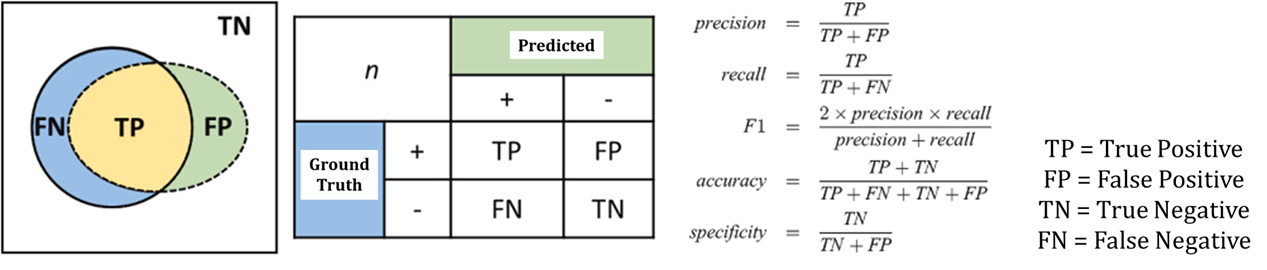

In [ ]:
# Here we define the evaluation metrics - Precision, Recall, F1-Score

os.environ["SM_FRAMEWORK"] = "tf.keras"

# Library with segmentation metrics
import segmentation_models as sm


metrics = [sm.metrics.Precision(threshold=0.5),sm.metrics.Recall(threshold=0.5),sm.metrics.FScore(threshold=0.5,beta=1)]

### Loss Function Defination
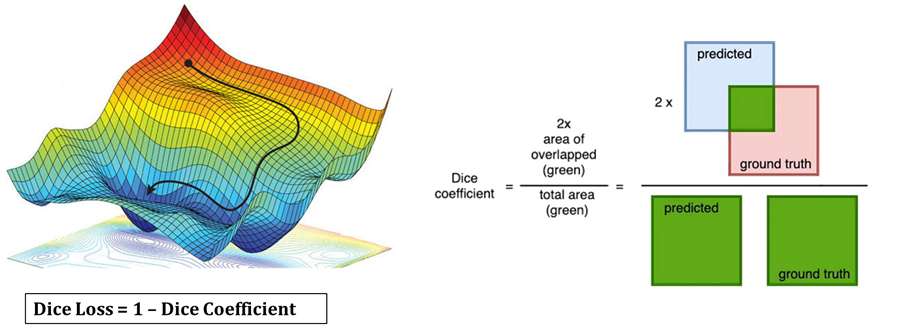

In [ ]:
# Function for Dice Loss function

smooth = 1

def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

### U-Net Model Defination and Training

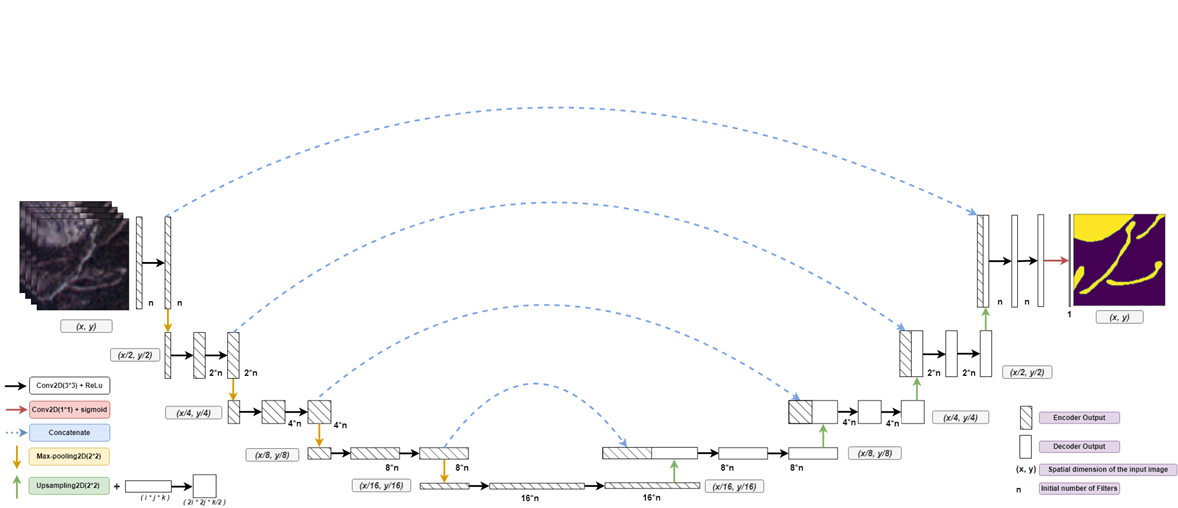

In [ ]:

# Size of the tiles
size = X_train.shape[2] # This line takes the value of the 3rd index which in this is taken from X_train shape = 249, 256, 256, 4 that is 256.

# Image bands
img_bands = X_train.shape[3] # This line takes the value of the 4th index which in this is taken from X_train shape = 249, 256, 256, 4 that is 4.

# Loss function. We assign the variable called "loss" which takes the dice_loss loss function.
loss=dice_loss

# Number of filters in the first layer. We set a range of the number of filters for the convolutional layers.
filters = [8, 16, 32, 64]

# Learning rates for the ADAM optimizer that we use in the model. An activation function decides whether a neuron should be activated or not.

lr = [0.001, 0.0001, 5e-5, 1e-5]

# Batch sizes. This considers how many patches the model will take during the training phases. A value of 4 means 4 patches of images (from 249) will be taken as a batch while training simultaneously.
batch_size = [2, 4, 8, 16, 32, 64]

# Epochs. The number of iterations the model will train.
epochs = 500

# Dictionary that will save the results. We first make an empty dictionary so that later we can save/store all the important configurations that we experimented with and report at the end in nice Excel CSVs and Plots.
dic = {}

# Hyperparameters. These are the keys where the associated information for each hyperparameter will be saved.
dic["model"] = [] # Name of the model
dic["batch_size"] = [] # Batch Size
dic["learning_rate"] = [] # Learning rate
dic["filters"] = [] # Number of filters

# Metrics on the test set. It will save the metrics after evaluating the moedl on the test set.
dic["training_loss"] = []
dic["training_precision"] = []
dic["training_recall"] = []
dic["training_f1_score"] = []

dic["validation_loss"] = []
dic["validation_precision"] = []
dic["validation_recall"] = []
dic["validation_f1_score"] = []

dic["test_loss"] = []
dic["test_precision"] = []
dic["test_recall"] = []
dic["test_f1_score"] = []

dic["Computation Time (min)"] = []


## Here we perform a nested for-loop to check all possible hyperparameter combinations that we set above.

# loop over all the filters in the filter list
for fiilter in filters:
    # loop over the learning rates
    for learning_rate in lr:
        # loop over all batch sizes in batch_size list
        for batch in batch_size:
            print('_______________________________________________________________________________')
            print('Filters: ', fiilter)
            print('Learning rate: ', learning_rate)
            print('Batch size: ', batch)
            start_time = time.time()

            # We define the model architecture here.
            def unet(lr,filtersFirstLayer, pretrained_weights = None,input_size = (size,size,img_bands)):
                inputs = Input(input_size)

                conv1 = Conv2D(filtersFirstLayer, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(inputs)
                conv1 = Conv2D(filtersFirstLayer, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv1)
                pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

                conv2 = Conv2D(filtersFirstLayer*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(pool1)
                conv2 = Conv2D(filtersFirstLayer*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv2)
                pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

                conv3 = Conv2D(filtersFirstLayer*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(pool2)
                conv3 = Conv2D(filtersFirstLayer*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv3)
                pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

                conv4 = Conv2D(filtersFirstLayer*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(pool3)
                conv4 = Conv2D(filtersFirstLayer*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv4)
                pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

                conv5 = Conv2D(filtersFirstLayer*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(pool4)
                conv5 = Conv2D(filtersFirstLayer*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv5)

                up6 = Conv2D(filtersFirstLayer*8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(UpSampling2D(size = (2,2))(conv5))
                merge6 = concatenate([conv4,up6], axis = 3)
                conv6 = Conv2D(filtersFirstLayer*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(merge6)
                conv6 = Conv2D(filtersFirstLayer*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv6)

                up7 = Conv2D(filtersFirstLayer*4, 2, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(UpSampling2D(size = (2,2))(conv6))
                merge7 = concatenate([conv3,up7], axis = 3)
                conv7 = Conv2D(filtersFirstLayer*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(merge7)
                conv7 = Conv2D(filtersFirstLayer*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv7)

                up8 = Conv2D(filtersFirstLayer*2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(UpSampling2D(size = (2,2))(conv7))
                merge8 = concatenate([conv2,up8], axis = 3)
                conv8 = Conv2D(filtersFirstLayer*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(merge8)
                conv8 = Conv2D(filtersFirstLayer*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv8)

                up9 = Conv2D(filtersFirstLayer, 2, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(UpSampling2D(size = (2,2))(conv8))
                merge9 = concatenate([conv1,up9], axis = 3)
                conv9 = Conv2D(filtersFirstLayer, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(merge9)
                conv9 = Conv2D(filtersFirstLayer, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv9)
                
                conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

                model = Model(inputs, conv10)

                # We initialise the ADAM optimizer here with the different learning rates that we assigned earlier.
                model.compile(optimizer = Adam(learning_rate = lr), loss = loss, metrics = metrics)

                model.summary()

                if(pretrained_weights):
                    model.load_weights(pretrained_weights)

                return model

            # Load the model in a new variable called "model".
            model = unet(filtersFirstLayer= fiilter, lr = learning_rate, input_size = (size,size,img_bands))

            #To use pre-trained weights
            pretrained_weights_path = (f'~/Thesis/MSI/Patch_256/weights/unet_size_256_filters_16_batch_size_32_lr_1e-5.hdf5')

            # Load the model with or without pre-trained weights
            model = unet(filtersFirstLayer=fiilter, lr=learning_rate, input_size=(size, size, img_bands),
                        pretrained_weights=pretrained_weights_path)

            # Stop the training if the validation loss does not decrease after 15 epochs. This is done to avoid over-fitting of the model. Please find the materials to understand overfitting here: https://www.v7labs.com/blog/overfitting
            early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                              patience = 15, 
                              restore_best_weights = True) 

            # Save the models only when validation loss decrease
            model_checkpoint = tf.keras.callbacks.ModelCheckpoint(f'~/Thesis/MSI/Patch_256/weights/unet_size_{size}_filters_{fiilter}_batch_size_{batch}_lr_{learning_rate}.hdf5',
                                                                  monitor='val_loss', mode='min',verbose=0, save_best_only=True,save_weights_only = True)

            # fit the model with 20% of the dataset used as the validation set
            history = model.fit(X_train,Y_train,
                                batch_size = batch,epochs=epochs,
                                validation_data=(X_val, Y_val), 
                                callbacks = [model_checkpoint, early_stop], verbose=1)
            end_time = time.time()
            total_time = end_time - start_time

            # summarize history for f1-score

            plt.plot(history.history['f1-score'])
            plt.plot(history.history['val_f1-score'])
            plt.title('model f1-score')
            plt.ylabel('f1-score')
            plt.xlabel('epoch')
            plt.legend(['train', 'validation'], loc='upper left')

            # save plots locally
            plt.savefig(f"~/Thesis/MSI/Patch_256/plots/unet_size_{size}_filters_{fiilter}_batch_size_{batch}_lr_{learning_rate}_f1_score.png")
            plt.show()

            # summarize history for loss
            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.title('model loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'validation'], loc='upper left')
            plt.savefig(f"~/Thesis/MSI/Patch_256/plots/unet_size_{size}_filters_{fiilter}_batch_size_{batch}_lr_{learning_rate}_val_loss.png")
            plt.show()

            # load unet to evaluate the test data
            load_unet = unet(filtersFirstLayer= fiilter, lr = learning_rate,input_size=(size,size,img_bands))
            
            # load the last saved weight from the training
            load_unet.load_weights(f"~/Thesis/MSI/Patch_256/weights/unet_size_{size}_filters_{fiilter}_batch_size_{batch}_lr_{learning_rate}.hdf5")

           # Here, we evaluate the model performance on the test set, a set of data that the model has never seen before and therefore remains an objective tool to test the performance of the model.
            res_1= load_unet.evaluate(X_test,Y_test)

            # save results on the dictionary and then output them all in a Excel CSV file.
            dic["model"].append("Unet")
            dic["batch_size"].append(batch)
            dic["learning_rate"].append(learning_rate)
            dic["filters"].append(fiilter)
            dic["training_loss"].append(np.mean(history.history["loss"][-2:]))
            dic["training_precision"].append(np.mean(history.history["precision"][-3:]))
            dic["training_recall"].append(np.mean(history.history["recall"][-4:]))
            dic["training_f1_score"].append(np.mean(history.history["f1-score"][-5:]))

            dic["validation_loss"].append(np.mean(history.history["val_loss"][-6:]))
            dic["validation_precision"].append(np.mean(history.history["val_precision"][-7:]))
            dic["validation_recall"].append(np.mean(history.history["val_recall"][-8:]))
            dic["validation_f1_score"].append(np.mean(history.history["val_f1-score"][-9:]))

            dic["test_loss"].append(res_1[0])
            dic["test_precision"].append(res_1[1])
            dic["test_recall"].append(res_1[2])
            dic["test_f1_score"].append(res_1[3])

            dic["Computation Time (min)"].append((total_time/60))

            # Convert results to a dataframe
            results = pd.DataFrame(dic)

            # Export as csv
            results.to_csv(f'~/Thesis/MSI/Patch_256/csv/results_Unet.csv', index = False)


### Sensitivity Analysis on Test Data

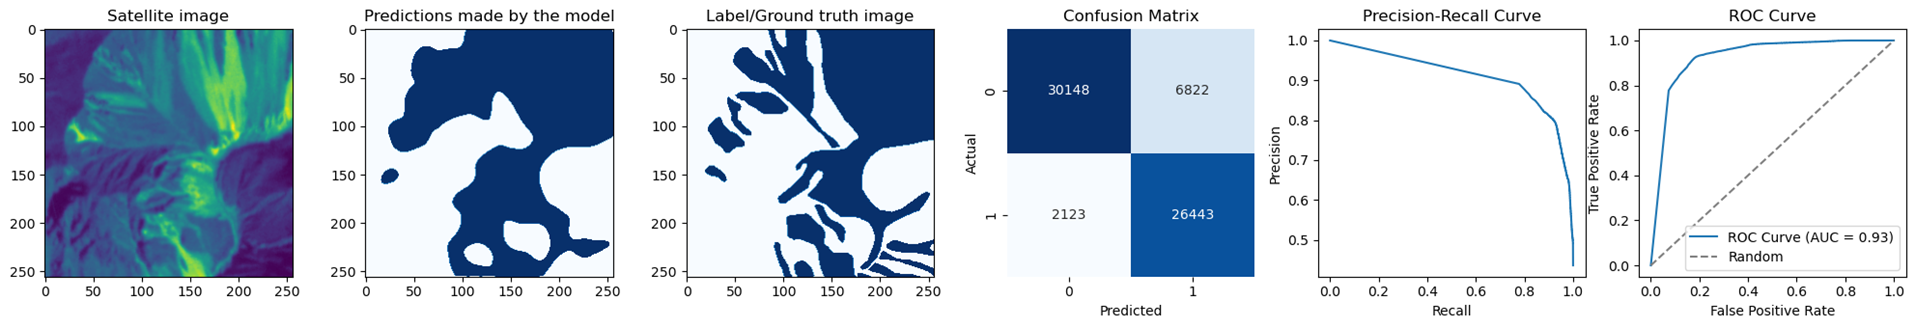

In [ ]:

# Loading the model weights
unet_best = unet(filtersFirstLayer=16, lr=1e-05, input_size=(size, size, img_bands))
unet_best.load_weights(f'~/Thesis/MSI/Patch_256/weights/unet_size_256_filters_16_batch_size_32_lr_1e-05.hdf5')

no = X_test.shape[0]

# Initialize variables to accumulate confusion matrices and precision-recall curve values
total_cm = np.zeros((2, 2), dtype=int)
all_tpr, all_fpr, all_precision, all_recall, all_mcc, all_f1 = [], [], [], [], [], []


# Initialize variables to accumulate confusion matrices and precision-recall curve values
total_cm = np.zeros((2, 2), dtype=int)
all_tpr, all_fpr, all_precision, all_recall, all_mcc, all_f1 = [], [], [], [], [], []


# Plot predictions on the test set and display the confusion matrix
for i in range(no):
    preds_train_1 = unet_best.predict(np.expand_dims(X_test[i], axis=0), verbose=0)
    preds_train_t1 = (preds_train_1 > 0.9).astype(np.uint8)

    # Set the figure size for each subplot individually
    f, axarr = plt.subplots(1, 6, figsize=(25, 10))  # Add extra subplots for precision-recall and ROC curves

    # Customizing color palettes
    cmap_satellite = 'viridis'
    cmap_label_predicted = 'Blues'
    cmap_confusion = 'Blues'

    # Plot satellite image
    axarr[0].imshow(X_test[i][:, :, 3], cmap=cmap_satellite)
    axarr[0].set_title("Satellite image")

    # Plot predictions made by the model
    axarr[1].imshow(np.squeeze(preds_train_t1), cmap=cmap_label_predicted)
    axarr[1].set_title("Predictions made by the model")

    # Plot label/ground truth image
    axarr[2].imshow(np.squeeze(Y_test[i]), cmap=cmap_label_predicted)
    axarr[2].set_title("Label/Ground truth image")
    

    # Calculate confusion matrix
    y_true_raw = np.squeeze(Y_test[i]).flatten()
    y_true = (y_true_raw > 0.9).astype(np.uint8)
    y_pred = np.squeeze(preds_train_t1).flatten()
    cm = confusion_matrix(y_true, y_pred)
    

    # Accumulate confusion matrices
    total_cm += cm

    # Display the confusion matrix with a blue color palette using seaborn
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap_confusion, cbar=False, ax=axarr[3], square=True, cbar_kws={'shrink': 0.8})
    axarr[3].set_title("Confusion Matrix")
    axarr[3].set_xlabel("Predicted")
    axarr[3].set_ylabel("Actual")
    


    # Set the figure size for precision-recall curve
    precision, recall, threshold = precision_recall_curve(y_true.flatten(), preds_train_1.flatten())
    auc_pr = auc(recall, precision)
    axarr[4].plot(recall, precision, label=f'Precision-Recall Curve (AUC = {auc_pr:.2f})')
    axarr[4].set_xlabel('Recall')
    axarr[4].set_ylabel('Precision')
    axarr[4].set_title('Precision-Recall Curve')

    # Set the figure size for ROC curve
    fpr, tpr, _ = roc_curve(y_true.flatten(), preds_train_1.flatten())
    auc_roc = auc(fpr, tpr)
    axarr[5].plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_roc:.2f})')
    axarr[5].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
    axarr[5].set_xlabel('False Positive Rate')
    axarr[5].set_ylabel('True Positive Rate')
    axarr[5].set_title('ROC Curve')
    axarr[5].legend()

    # Set the figure size for precision-recall curve
    f.set_figheight(3.33)
    f.set_figwidth(25)

    # Store ROC and precision-recall curve values for summary
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_precision.append(precision)
    all_recall.append(recall)

    plt.show()

    # Calculate MCC score
    mcc = matthews_corrcoef(y_true, y_pred)
    all_mcc.append(mcc)

    # Calculate F1-score
    f1 = f1_score(y_true, y_pred)
    all_f1.append(f1)
    


# Display the final summary confusion matrix
f, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.heatmap(total_cm, annot=True, fmt="d", cmap="Blues", cbar=True, ax=ax, square=True, cbar_kws={'shrink': 0.8})
ax.set_title("Final Summary Confusion Matrix")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.show()

# Plot summary ROC curve
plt.figure(figsize=(10, 8))
for fpr, tpr in zip(all_fpr, all_tpr):
    plt.plot(fpr, tpr, color='orange', alpha=0.6)
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Summary ROC Curve')
plt.legend()
plt.show()

# Plot summary precision-recall curve
plt.figure(figsize=(10, 8))
for precision, recall in zip(all_precision, all_recall):
    plt.plot(recall, precision, color='orange', alpha=0.6)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Summary Precision-Recall Curve')
plt.legend()
plt.show()